## Imports

In [151]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
import pandas as pd
import numpy as np
import os
from ann_visualizer.visualize import ann_viz
from keras.layers import Dense, Input, InputLayer, Flatten , Dropout
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout , BatchNormalization
from keras import regularizers as rz
from keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential, Model
from  matplotlib import pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import matplotlib.image as mpimg
import os
%matplotlib inline

In [152]:
input_dir="/Users/snouto/Downloads/output2"
data_dir = "/Users/snouto/Downloads/melanoma"
metadata_file="/Users/snouto/Documents/melanoma_deeplearning/HAM10000_metadata.csv"
input_shape=(64,64,3)
epochs=5
kernel_size= (3,3)
batch_size=1

# You can control the number of classes from below 
# and don't forget to change loss function if num_classes > 2 to categorical_crossentropy
# and the activation into softmax
num_classes=2
loss_func='binary_crossentropy'
activation='sigmoid'

## Explanatory Data Analysis

In [153]:
metadata = pd.read_csv(metadata_file)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [154]:
metadata.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [155]:
metadata.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [156]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


<AxesSubplot:>

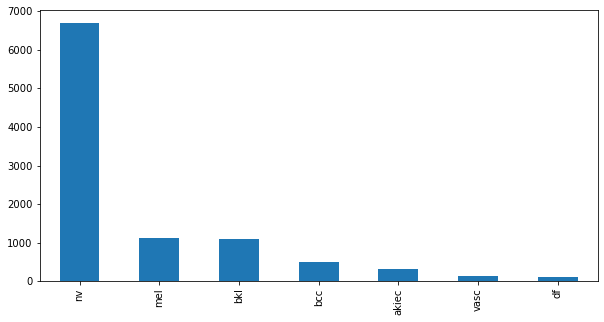

In [157]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

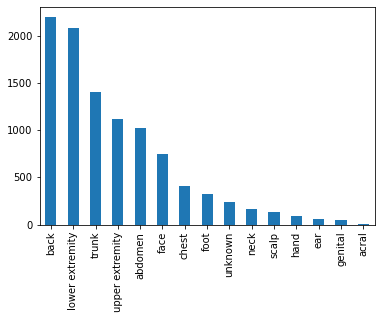

In [158]:
metadata['localization'].value_counts().plot(kind='bar')

In [159]:
indexes = metadata[metadata['sex'] == 'unknown'].index

In [160]:
metadata.drop(indexes,inplace=True)

<AxesSubplot:>

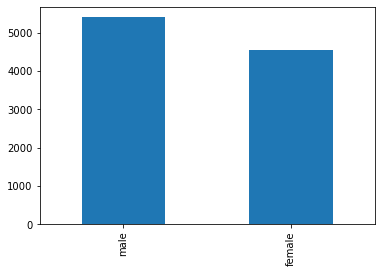

In [161]:
metadata['sex'].value_counts().plot(kind='bar')

In [162]:
metadata.dropna(inplace=True)


## Functions

In [163]:
#output_dir = "/home/genomicslab/nn/out"
# This function will prepare images directory that will act as an input directory for ImageDataGenerator
def prepare_input_features(data_path,metadata_file,output_dir):
    import os , shutil
    import pandas as pd
    from sklearn.model_selection import train_test_split
    if not os.path.exists(data_path):
        raise Exception("Data Path doesn't exist")
    if not metadata_file:
        raise Exception("Please specify a metadata file to load")

    print(f"Loading metadata from : {metadata_file}")
    metadata = pd.read_csv(metadata_file)
    metadata_train,metadata_test = train_test_split(metadata,test_size=0.1)
    metadata_train, metadata_val = train_test_split(metadata_train,test_size=0.1)
    print(f"Preparing features to output Directory : {output_dir}")
    all_data = [("train",metadata_train),("test",metadata_test),("val",metadata_val)]
    for ds_type , df in all_data:
        print(f"Preparing {ds_type}.......")
        for index, row in df.iterrows():
            output_dir_name = os.path.join(output_dir,ds_type,row['dx'])
            if not os.path.exists(output_dir_name):
                os.makedirs(output_dir_name)
            data_img_loc = os.path.join(data_path,f"{row['image_id']}.jpg")
            if not os.path.exists(data_img_loc):
                continue
            shutil.move(data_img_loc,output_dir_name)
            print(f"Moved: {data_img_loc}")
        print(f"#"*100)

    print("All Input Features Prepared")

In [164]:
def show_images(img_loc,display_size=(3,2)):
    from matplotlib import pyplot as plt
    import random
    from collections import defaultdict
    import cv2
    plt.figure(figsize = (20,20))
    bucket = defaultdict(list)
    if not img_loc:
        raise Exception("Provide image directory. It should not be empty")
    classes = [os.path.join(img_loc,d) for d in os.listdir(img_loc)]
    random.shuffle(classes)
    for cls in range(0,display_size[0]):
        curr_cls = classes[cls]
        counter = 0
        for img in os.listdir(curr_cls):
            if counter >= display_size[1]:
                break
            curr_file = os.path.join(curr_cls,img)
            bucket[os.path.basename(curr_cls)].append(cv2.imread(curr_file))
            counter += 1
    rows ,  cols = display_size
    counter = 1
    for key in bucket.keys():
        imgs = bucket[key]
        for img in imgs:
            plt.subplot(rows,cols,counter)
            plt.imshow(img,interpolation='nearest', aspect='auto')
            counter += 1

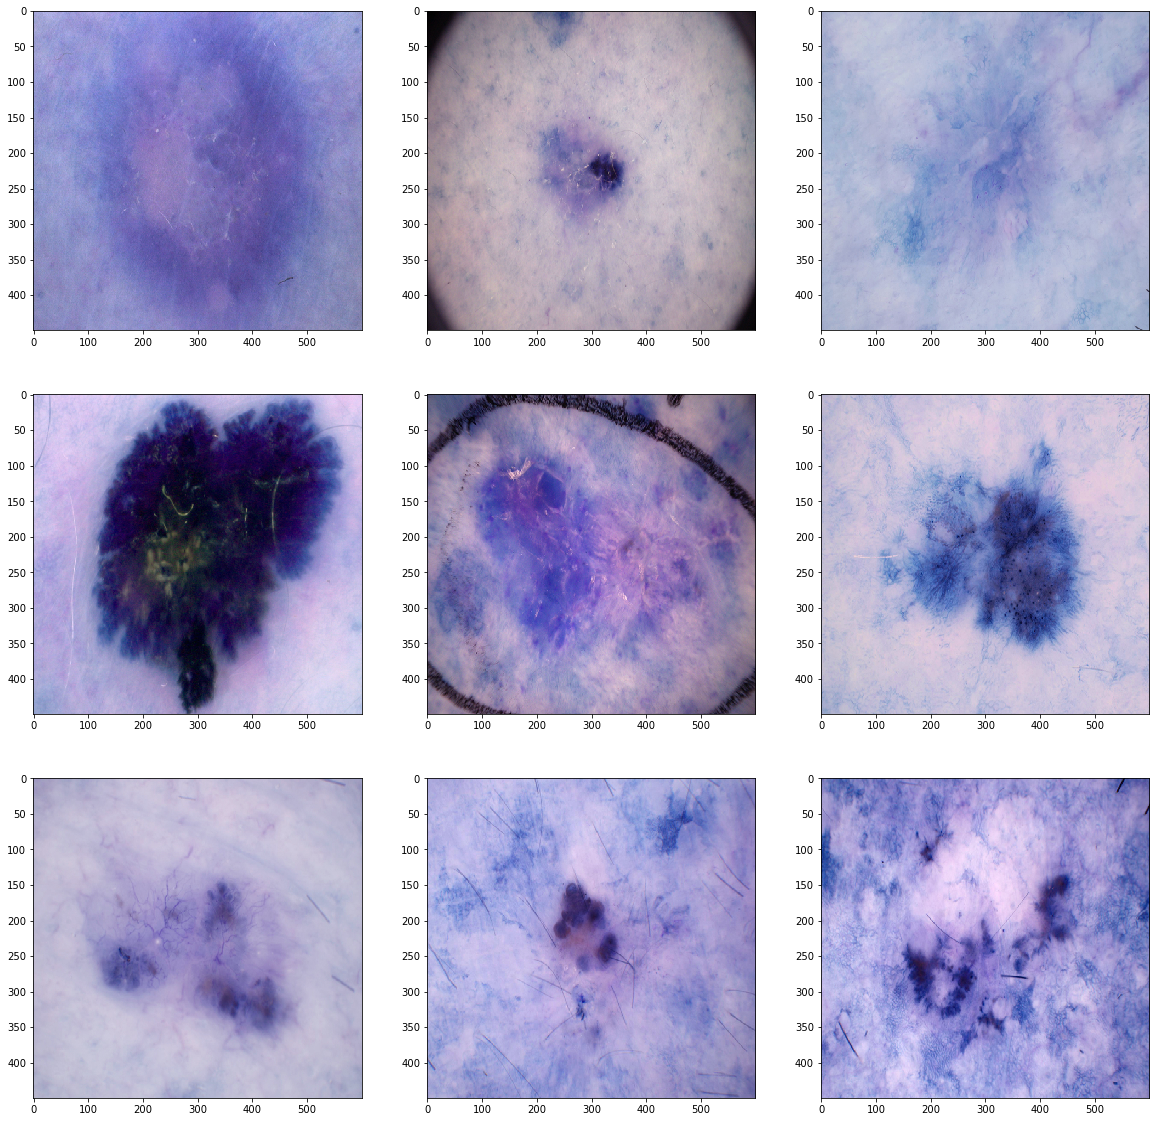

In [165]:
show_images("/Users/snouto/Downloads/output/train",display_size=(3,3))


## Image Augmentation (Generating rotated, skewed and scaled) images

In [166]:
# this function will generate different images based on the image augementation chosen 
#in the image Data Generator instance
def generate_augmentation(generator: ImageDataGenerator,folder,files_size=50,augment_size=10,prefix='augmented'):
    from keras.preprocessing import image
    for root , dirs , files in os.walk(folder,topdown=False):
        for file in files[:files_size]:
            file_loc = os.path.join(root,file)
            bn = os.path.basename(file_loc)
            _ , ext = os.path.splitext(file_loc)
            ext = ext.replace('.','')
            if not ext.lower() in ['jpeg','jpg','png']:
                continue
            img = image.load_img(file_loc)
            image_arr = image.img_to_array(img)
            image_arr = image_arr.reshape((1,) + image_arr.shape)
            counter = 0 
            for _ in generator.flow(image_arr,batch_size=2,save_to_dir=root,save_prefix=f"{bn}.{prefix}",save_format=ext):
                counter += 1
                print(f"{counter}. Augmented Image saved to : {os.path.join(root,bn+'.'+prefix)}")
                if counter > augment_size:
                    break

In [167]:
#generate_augmentation(image_datagen,folder=os.path.join(input_dir,"val"),files_size=50)

## Helper Functions

In [168]:
def get_generators():
    # Creating the training Generator
    image_datagen = ImageDataGenerator( rescale=1 / 255.0,
                                          rotation_range=20,
                                          zoom_range=0.05,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          shear_range=0.05,
                                          horizontal_flip=True,
                                          fill_mode="nearest",
                                          validation_split=0.20)

    train_generator = image_datagen.flow_from_directory(
        directory=os.path.join(input_dir,"train"),
        target_size=(input_shape[0],input_shape[1]),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='training',
        
        seed=42
    )
    val_generator = image_datagen.flow_from_directory(
        directory=os.path.join(input_dir,"val"),
        target_size=(input_shape[0],input_shape[1]),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='validation',
        
        seed=42
    )
    test_generator = image_datagen.flow_from_directory(
        directory=os.path.join(input_dir,"test"),
        target_size=(input_shape[0],input_shape[1]),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        
        
        seed=42
    )
    
    return train_generator, test_generator , val_generator , image_datagen



In [170]:
def predict_img(model,img_path):
    from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
    BENIGN,MALIGNANT = 0,1
    current_img = load_img(img_path, target_size=(input_shape[0],input_shape[1]))
    current_img  = img_to_array(current_img)
    current_img = current_img.reshape((1, current_img.shape[0], current_img.shape[1], current_img.shape[2]))
    return model.predict(current_img)
    

In [171]:
def plot_acc(hist,title='Model Accuracy'):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch(s)')
    plt.legend(['train','test'],loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Baseline Model(s)



In [172]:
# Creating the training Generator
train_generator , test_generator , val_generator , image_datagen = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [186]:
# AdaBoost,Kneighbors Model ,XGBClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

create_xgb_model = lambda :  xgb.XGBClassifier( 
                       )

create_ab_model = lambda : AdaBoostClassifier()
create_knn_model = lambda : KNeighborsClassifier()

bl_model = create_xgb_model()


In [187]:
def get_features(generator,sample_size=4000):
    x_train = []
    y_train = []
    counter = 0 
    for x,y in train_generator:
        counter += 1
        x_train.append(x)
        y_train.append(y)
        if counter >= sample_size:
            break

    final_shape = (len(x_train),input_shape[0]*input_shape[1]*input_shape[2])
    x_features = np.reshape(x_train,final_shape)
    return x_features , np.array([np.argmax(y) for y in y_train]).astype('int')

In [188]:
def reduce_dimensions(x_train_total,window_size=1000):
    total = []
    for j in range(x_train_total.shape[0]):
        x_train_new = []
        x_train = np.array(x_train_total[j])
        L = x_train.shape[0]
        odds = L % window_size
        new_L = L - odds
        loops = int(new_L / window_size)
        for i in range(int(loops)):
            i = int(i)
            ma = np.mean(x_train[int(i*window_size):int(window_size+(i*window_size)+1)])
            x_train_new.append(ma)
        last_mean = x_train[loops*window_size:window_size+(i*window_size)+1]
        x_train_new.append(last_mean)
        total.append(x_train_new)
    scaler = StandardScaler()
    output = np.array(total)
    output = scaler.fit_transform(output)
    return output
    
    
    

## Training BaseLine Model

In [189]:
x_train , y_train = get_features(train_generator)

In [190]:
x_train_reduced = reduce_dimensions(x_train)

In [191]:
x_train_reduced.shape

(4000, 13)

In [192]:
x_train_reduced

array([[ 0.92150984,  0.97772049,  1.02899758, ...,  0.09308704,
         0.42392343,  1.25512981],
       [ 0.23817642,  0.19877851,  0.29364532, ...,  0.12150626,
         0.13900708,  0.87628986],
       [ 0.86833914,  0.72234394,  0.19175623, ...,  1.50139835,
         1.57072983,  0.90814998],
       ...,
       [-0.5788002 , -0.4822869 , -0.423057  , ..., -0.64766595,
        -0.79778335, -1.98293249],
       [-0.08817126, -0.07572197, -0.08978696, ...,  0.38100364,
         0.34640789, -0.68400489],
       [-0.92636732, -0.69206516, -0.34323586, ..., -0.59596901,
        -0.71840286, -1.4862576 ]])

In [193]:
# Do Training
bl_model.fit(x_train_reduced,pd.Series(y_train))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Baseline Train Accuracy

In [194]:
x_train , y_train = get_features(train_generator)
x_train = reduce_dimensions(x_train)
y_train_pred = bl_model.predict(x_train)
accuracy_score(y_train,y_train_pred)

0.8

## Baseline Validation Accuracy

In [195]:
x_validation , y_validation = get_features(val_generator)
x_validation = reduce_dimensions(x_validation)
y_val_pred = bl_model.predict(x_validation)
accuracy_score(y_validation,y_val_pred)

0.79775

## Baseline Test Accuracy

In [196]:
# Test 
x_test , y_test = get_features(test_generator)
x_test = reduce_dimensions(x_test)

In [197]:
y_test_pred = bl_model.predict(x_test)

In [198]:
# Perform accuracy report
accuracy_score(y_test,y_test_pred)

0.8115

##  Neural net builder Function



In [199]:
def get_nn_model(layers=[]):
    model = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    Flatten(),
    keras.layers.Dense(128,input_dim=input_shape[0]*input_shape[1]*input_shape[2]),
    keras.layers.Dense(units=128, activation="relu"),
])
    for layer in layers:
        model.add(layer)
    model.add(keras.layers.Dense(units=num_classes, activation=activation))
    model.compile("adam", loss=loss_func, metrics=["acc"])
    return model
##simple nural network 

## Simple NN Model

In [200]:
# Creating the training Generator
train_generator , test_generator , val_generator , image_datagen = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [201]:
simple_nn = get_nn_model()
simple_nn_hist = simple_nn.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
6490/6490 [==============================] - 91s 14ms/step - loss: 1.2407 - acc: 0.7683 - val_loss: 0.4766 - val_acc: 0.8333
Epoch 2/10
6490/6490 [==============================] - 92s 14ms/step - loss: 0.5249 - acc: 0.8014 - val_loss: 0.4595 - val_acc: 0.8333
Epoch 3/10
6490/6490 [==============================] - 93s 14ms/step - loss: 0.4985 - acc: 0.8017 - val_loss: 0.4541 - val_acc: 0.8333
Epoch 4/10
6490/6490 [==============================] - 95s 15ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4543 - val_acc: 0.8333
Epoch 5/10
6490/6490 [==============================] - 88s 14ms/step - loss: 0.4981 - acc: 0.8017 - val_loss: 0.4531 - val_acc: 0.8333
Epoch 6/10
6490/6490 [==============================] - 87s 13ms/step - loss: 0.4983 - acc: 0.8017 - val_loss: 0.4539 - val_acc: 0.8333
Epoch 7/10
6490/6490 [==============================] - 89s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4550 - val_acc: 0.8333
Epoch 8/10
6490/6490 [==========================

In [202]:
x,y = train_generator[0]
x.shape , y.shape

((1, 64, 64, 3), (1, 2))

In [253]:
x,y = train_generator[0]
x.shape , y.reshape(1,2).shape

((1, 64, 64, 3), (1, 2))

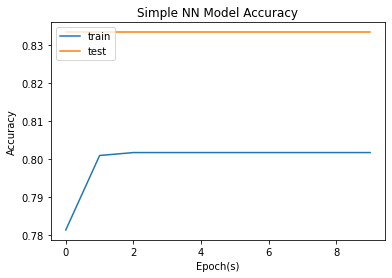

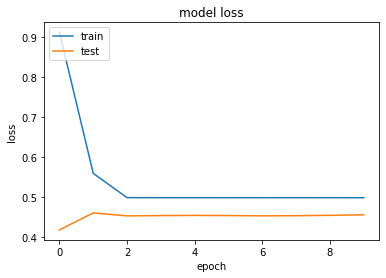

In [65]:
# Plot Accuracy Vs Epochs
plot_acc(simple_nn_hist,title='Simple NN Model Accuracy')

## Medium NN Model

In [67]:
layers = []
layers.append(Dense(128,activation='relu',kernel_initializer='uniform'))
layers.append(BatchNormalization())
layers.append(Dropout(0.5))
layers.append(Dense(64,activation='relu',kernel_initializer='uniform'))
layers.append(Dense(32,activation='relu',kernel_initializer='uniform'))

complex_nn = get_nn_model(layers)

In [68]:
complex_nn_hist = complex_nn.fit_generator(train_generator,epochs=10,validation_data=val_generator)

<ipython-input-68-255165102193>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  complex_nn_hist = complex_nn.fit_generator(train_generator,epochs=10,validation_data=val_generator)


Epoch 1/10
6490/6490 [==============================] - 95s 14ms/step - loss: 0.5290 - acc: 0.8017 - val_loss: 0.4543 - val_acc: 0.8333
Epoch 2/10
6490/6490 [==============================] - 92s 14ms/step - loss: 0.4983 - acc: 0.8017 - val_loss: 0.4542 - val_acc: 0.8333
Epoch 3/10
6490/6490 [==============================] - 91s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4525 - val_acc: 0.8333
Epoch 4/10
6490/6490 [==============================] - 95s 15ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4519 - val_acc: 0.8333
Epoch 5/10
6490/6490 [==============================] - 93s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4548 - val_acc: 0.8333
Epoch 6/10
6490/6490 [==============================] - 93s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4524 - val_acc: 0.8333
Epoch 7/10
6490/6490 [==============================] - 92s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4536 - val_acc: 0.8333
Epoch 8/10
6490/6490 [==========================

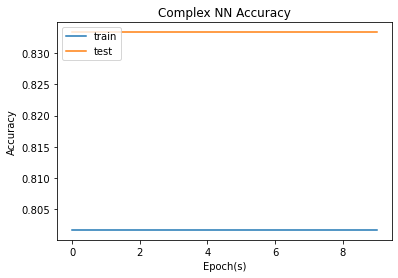

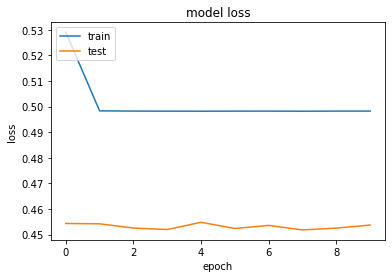

In [69]:
plot_acc(complex_nn_hist,title='Complex NN Accuracy')

## Complex NN Model

In [224]:

L2 = 50
DROP = 0.03
complex_nn_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    Flatten(),
    keras.layers.Dense(128,input_dim=input_shape[0]*input_shape[1]*input_shape[2]),
    keras.layers.Dense(units=128, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=120, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=100, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=80, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=60, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(.5*DROP),
    keras.layers.Dense(units=40, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(.5*DROP),
    keras.layers.Dense(units=20, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
#     keras.layers.Dropout(DROP),
    keras.layers.Dense(units=num_classes,activation=activation),
])
complex_nn_model.compile(
    keras.optimizers.Adam(lr=0.002), loss=loss_func,
    metrics=["acc"])

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [225]:
cmodel_hist = complex_nn_model.fit_generator(train_generator,epochs=10,validation_data=val_generator)

<ipython-input-225-18dd636ddf71>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cmodel_hist = complex_nn_model.fit_generator(train_generator,epochs=10,validation_data=val_generator)


Epoch 1/10
6490/6490 [==============================] - 86s 13ms/step - loss: 118.5641 - acc: 0.8012 - val_loss: 0.4552 - val_acc: 0.8333
Epoch 2/10
6490/6490 [==============================] - 85s 13ms/step - loss: 0.5019 - acc: 0.8017 - val_loss: 0.4557 - val_acc: 0.8333
Epoch 3/10
6490/6490 [==============================] - 85s 13ms/step - loss: 0.5049 - acc: 0.8017 - val_loss: 0.4588 - val_acc: 0.8333
Epoch 4/10
6490/6490 [==============================] - 84s 13ms/step - loss: 0.5041 - acc: 0.8017 - val_loss: 0.4573 - val_acc: 0.8333
Epoch 5/10
6490/6490 [==============================] - 82s 13ms/step - loss: 0.5049 - acc: 0.8017 - val_loss: 0.4628 - val_acc: 0.8333
Epoch 6/10
6490/6490 [==============================] - 81s 12ms/step - loss: 0.5053 - acc: 0.8017 - val_loss: 0.4583 - val_acc: 0.8333
Epoch 7/10
6490/6490 [==============================] - 79s 12ms/step - loss: 0.5044 - acc: 0.8017 - val_loss: 0.4552 - val_acc: 0.8333
Epoch 8/10
6490/6490 [========================

In [226]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [227]:
x,y = next(trainer(test_generator))
y

array([[1., 0.]])

In [228]:
complex_nn_model.predict(x)

array([[0.8032341 , 0.19782907]], dtype=float32)

In [229]:
predict_img(complex_nn_model, '/Users/snouto/Downloads/output2/train/malignant/ISIC_0026909.jpg')

array([[0.8032341 , 0.19782907]], dtype=float32)

In [230]:
complex_nn_model.save("/Users/snouto/Downloads/model/skin_cancer.h5")

In [231]:
complex_nn_model.evaluate(test_generator)

1002/1002 [==============================] - 10s 10ms/step - loss: 0.5088 - acc: 0.7974


[0.5087559223175049, 0.7974051833152771]

In [232]:
train_generator , test_generator , val_generator , image_datagen = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [233]:
x,y = next(trainer(train_generator))

In [234]:
x , y = train_generator[6202]
train_generator.filepaths[6202]
y

array([[1., 0.]], dtype=float32)

In [235]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [236]:
x,y = train_generator[1]
simple_nn.save('/Users/snouto/Downloads/model/skin_cancer.h5')

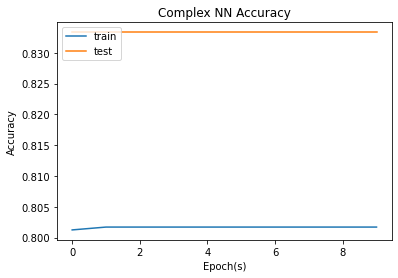

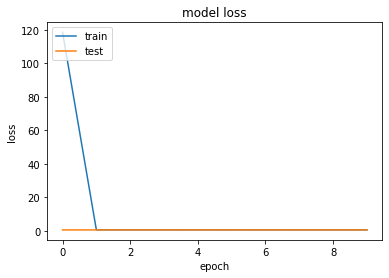

In [237]:
plot_acc(cmodel_hist,title='Complex NN Accuracy')

In [238]:
# This function will prepare CNN model
def prepare_model(kernel_size=(3,3),input_shape=input_shape,pool_size=(2,2),conv_layers=[],mlp_layers=[]):
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

    model = Sequential()
    model.add(Conv2D(128,kernel_size=kernel_size,activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    for layer in conv_layers:
        model.add(layer)
    model.add(Flatten())
    # MLP Starts
    model.add(Dense(16, activation='relu'))
    for mlp_layer in mlp_layers:
        model.add(mlp_layer)
    # The final output layer
    model.add(Dense(num_classes, activation=activation))
    model.compile(loss=loss_func,optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
    return model


## Training CNN (Through ImageDataGenerator)

In [239]:
# Creating the training Generator
train_generator , test_generator , val_generator , image_datagen = get_generators()
# create the CNN model
model = prepare_model(input_shape=input_shape)

model_history = model.fit_generator(train_generator,epochs=1,validation_data = val_generator,
                                   callbacks=[
    keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)
])




Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


<ipython-input-239-eb08078d749e>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator,epochs=1,validation_data = val_generator,


6490/6490 [==============================] - 107s 16ms/step - loss: 0.6052 - accuracy: 0.8011 - val_loss: 0.5618 - val_accuracy: 0.8333 - lr: 0.0100


In [240]:
model.evaluate(test_generator)

1002/1002 [==============================] - 11s 11ms/step - loss: 0.5900 - accuracy: 0.7974


[0.5899576544761658, 0.7974051833152771]

In [241]:
x, y = train_generator[6]
model.predict(x)

array([[0.7595015 , 0.24049821]], dtype=float32)

In [242]:
counter = 0
for x,y in train_generator:
    if np.argmax(y) != 5:
        print(counter)
        print(train_generator.filepaths[counter])
        break
    counter += 1
    

0
/Users/snouto/Downloads/output2/train/benign/ISIC_0026267.jpg


## Visualizing Simple Convoluted NN (CNN Model)

In [249]:
#ann_viz(model)

## Training Medium CNN Model

In [250]:
# Get Fresh generators for training
train_generator , test_generator , val_generator , image_datagen = get_generators()
# create the CNN model
mmodel = prepare_model(input_shape=input_shape,conv_layers=[
    Conv2D(64,kernel_size=kernel_size,activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2))
],mlp_layers=[
    
    Dense(16, activation='relu')
])

mmodel_history = mmodel.fit_generator(train_generator,validation_data = val_generator)

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


<ipython-input-250-078e459423b5>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  mmodel_history = mmodel.fit_generator(train_generator,validation_data = val_generator)


6490/6490 [==============================] - 119s 18ms/step - loss: 0.5212 - accuracy: 0.7997 - val_loss: 0.4571 - val_accuracy: 0.8333


## Training Complex CNN Model

In [245]:
# Get Fresh generators for training
train_generator , test_generator , val_generator , image_datagen = get_generators()
# create the CNN model
cmodel = prepare_model(input_shape=input_shape,conv_layers=[
    Conv2D(64,kernel_size=kernel_size,activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,kernel_size=kernel_size,activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16,kernel_size=kernel_size,activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
],mlp_layers=[
    
    Dense(16, activation='relu')
])

cmodel_history = cmodel.fit_generator(train_generator,validation_data = val_generator)

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


<ipython-input-245-a171e0622df4>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cmodel_history = cmodel.fit_generator(train_generator,validation_data = val_generator)


6490/6490 [==============================] - 121s 19ms/step - loss: 0.5692 - accuracy: 0.8000 - val_loss: 0.4571 - val_accuracy: 0.8333


## Visualizing Complex Model (Complex CNN)

In [248]:
#ann_viz(cmodel)

## Prediction using CNN (Complex) Trained Models

In [251]:
# Test all test data set 
samples_len = len(test_generator.filenames)
predictions = cmodel.predict_generator(test_generator,steps=samples_len)
predictions

<ipython-input-251-3b2dd492c0e3>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = cmodel.predict_generator(test_generator,steps=samples_len)


array([[0.7879044 , 0.21209595],
       [0.7879044 , 0.21209595],
       [0.7879044 , 0.21209595],
       ...,
       [0.7879044 , 0.21209595],
       [0.7879044 , 0.21209595],
       [0.7879044 , 0.21209595]], dtype=float32)

In [252]:
# Calculate accuracy metrics for complex CNN
loss, acc = cmodel.evaluate_generator(test_generator, steps=samples_len, verbose=0)
acc

<ipython-input-252-49a2c11949f1>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = cmodel.evaluate_generator(test_generator, steps=samples_len, verbose=0)


0.7974051833152771

# Transfer Learning

Top Layer for Transfer Learning only
-----------------------------------------

In [ ]:
def get_toplayer(input_dim=4*4*2048):
    baseline = Sequential([
    Dense(128,input_dim=input_dim,activation='relu',
          kernel_regularizer=rz.l1_l2(l1=1e-5,l2=1e-4),
         bias_regularizer=rz.l2(1e-4),
         activity_regularizer=rz.l2(1e-5)),
    Dropout(0.5),
    Dense(64,activation='relu',kernel_regularizer=rz.l1_l2(l1=1e-5,l2=1e-4),
         bias_regularizer=rz.l2(1e-4),
         activity_regularizer=rz.l2(1e-5)),
    Dense(32,activation='relu',kernel_regularizer=rz.l1_l2(l1=1e-5,l2=1e-4),
         bias_regularizer=rz.l2(1e-4),
         activity_regularizer=rz.l2(1e-5)),
    Dropout(0.5),
    Dense(units=num_classes,activation=activation)
])
    baseline.compile(optimizer='adam',
                     loss=loss_func, metrics=['acc'])
    return baseline
    

In [ ]:
def get_pretrained_model(model_name):
    from tensorflow.keras import applications
    """
    This function will return a pretrained model based on its name, possible names: resnet , densenet, vgg16, vgg19, efficientnet
    :param model_name: the name of the pretrained model to return
    :return: an instance of the specified pretrained model
    """
    vargs = dict(include_top=False,weights='imagenet',input_shape=input_shape,classes=num_classes)
    if not model_name:
        return applications.VGG16(**vargs)
    elif model_name == 'resnet':
        return applications.ResNet152V2(**vargs)
    elif model_name == 'densenet':
        return applications.DenseNet201(**vargs)
    elif model_name == 'vgg19':
        return applications.VGG19(**vargs)
    elif model_name == 'efficientnet':
        return applications.EfficientNetB7(**vargs)
    elif model_name == 'mobilenet':
        return applications.MobileNetV2(**vargs)
        
    else:
        return applications.VGG16(**vargs)

In [ ]:
def get_features_using_pretrained_model(generator,model,directory,input_shape,sample_count=2000,batch_size=50):
    """
     This function will use an instance of ImageDataGenerator and a Pretrained Model to extract features from the pretrained model for
     the specified sample count and in batches
    :param generator: the ImageDataGenerator to use
    :param model: The specified pretrained model to use
    :param directory: The input directory containing images to extract features from.
    :param sample_count: The number of images to extract and return
    :param batch_size: the number of batches to return in each iteration
    :return: Features and labels
    """
    if None in [generator , model,directory,input_shape]:
        raise Exception("You have to specify ImageDataGenerator , Pretrained Model and a directory before extracting features.")
    shape = (sample_count,) + input_shape
    features = np.zeros(shape=shape)
    labels = np.zeros(shape=(sample_count,num_classes))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [ ]:
## Get Trained Model
resnet_pretrained_model = get_pretrained_model('resnet')

In [ ]:
resnet_pretrained_model.summary()

In [ ]:
## using Dense Net as pretrained model
densenet_pretrained_model = get_pretrained_model('densenet')

In [ ]:
densenet_pretrained_model.summary()

In [ ]:
efficientnet_pretrained_model = get_pretrained_model('efficientnet')

In [ ]:
efficientnet_pretrained_model.summary()

In [ ]:
vgg16_pretrained_model = get_pretrained_model('vgg16')

In [ ]:
vgg16_pretrained_model.summary()

In [ ]:
vgg19_pretrained_model = get_pretrained_model('vgg19')

In [ ]:
vgg19_pretrained_model.summary()

In [ ]:
# mobilenet 
mobilenet_pretrained_model = get_pretrained_model('mobilenet')

In [ ]:
mobilenet_pretrained_model.summary()

## Training using Pretrained Model(s) (Resnet , EfficientNet,VGG16,VGG19,DenseNet)

In [ ]:
# 1. Extract different image generators for Train , validation and test data set
train_generator , test_generator , val_generator , img_gen = get_generators()

In [ ]:
# 2. Extract features for the training , validation and test image set using the different image generator declared in step 1 above
current_model = resnet_pretrained_model
samples_count = 500
input_dim = (2, 2, 2048)
#input_dim = (4,4,2560)
# Train Features
train_features , train_labels = get_features_using_pretrained_model(train_generator,model=current_model,input_shape=input_dim,directory=input_dir,sample_count=samples_count,batch_size=batch_size)
# Validation Features
validation_features , validation_labels = get_features_using_pretrained_model(val_generator,model=current_model,input_shape=input_dim,directory=input_dir,sample_count=samples_count,batch_size=batch_size)
# Test Features
test_features , test_labels = get_features_using_pretrained_model(test_generator,model=current_model,input_shape=input_dim,directory=input_dir,sample_count=samples_count,batch_size=batch_size)

In [ ]:
# reshape for train , validation and test features
final_shape = (samples_count,input_dim[0]*input_dim[1]*input_dim[2])

train_features = np.reshape(train_features,final_shape)
validation_features = np.reshape(validation_features,final_shape)
test_features = np.reshape(test_features,final_shape)

In [ ]:
train_features.shape

In [ ]:
toplayer = get_toplayer(input_dim[0]*input_dim[1]*input_dim[2])

In [ ]:
input_dim[0]*input_dim[1]*input_dim[2]

In [ ]:
train_features.shape

In [ ]:
# Training New MLP on the output convoluted features from pretrained model for 50 epochs
#baseline_hist = toplayer.fit(train_features,train_labels,epochs=100,validation_data=(validation_features,validation_labels))
transfer_hist = complex_nn_model.fit(train_features,train_labels,epochs=100,validation_data=(validation_features,validation_labels))

In [ ]:
# save the model for mobile app
complex_nn_model.save("/Users/snouto/Downloads/model/skin_cancer.h5")

In [ ]:
train_generator.class_indices

## Epochs Vs Accuracy (Transfer Learning)

In [ ]:
plot_acc(transfer_hist,title='Transfer Learning Model Accuracy')

In [ ]:
## Using Callbacks [EarlyStopping] to restore the best weights for MLP training
baseline_hist = complex_nn_model.fit(train_features,train_labels,epochs=50,callbacks=[
    keras.callbacks.EarlyStopping(patience=4,verbose=1,restore_best_weights=True,monitor='accuracy'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)
],validation_data=(validation_features,validation_labels))

## Using Fine Tuning in Transfer Learning

In [ ]:
# 1. Extract different image generators for Train , validation and test data set
train_generator , test_generator , val_generator , _ = get_generators()

In [ ]:
from tensorflow.keras.models import Model

def create_transfer_finetuning_model(by_model=resnet_pretrained_model):

    # Freeze convolutional layers
    for layer in current_model.layers:
        layer.trainable = False

    x = current_model.output

    x = Flatten()(x)

    x = keras.layers.Dense(128,input_dim=input_shape[0]*input_shape[1]*input_shape[2])(x)
    x = keras.layers.Dense(units=128, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = keras.layers.Dropout(DROP)(x)
    x = keras.layers.Dense(units=120, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = keras.layers.Dropout(DROP)(x)
    x = keras.layers.Dense(units=100, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = keras.layers.Dropout(DROP)(x)
    x = keras.layers.Dense(units=80, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = keras.layers.Dropout(DROP)(x)
    x = keras.layers.Dense(units=60, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = keras.layers.Dropout(.5*DROP)(x)
    x = keras.layers.Dense(units=40, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(L2))(x)
    x = keras.layers.Dropout(.5*DROP)(x)
    x = keras.layers.Dense(units=20, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(L2))(x)
    #     keras.layers.Dropout(DROP),
    predictions = keras.layers.Dense(units=num_classes,activation=activation)(x)

    transfer_finetuning_model = Model(inputs = current_model.input , outputs=predictions)
    transfer_finetuning_model.compile('adam',loss=loss_func,metrics=['acc'])

    transfer_finetuning_model.summary()
    
    # Return the fine tuned transfer model with the selected pretrained model
    return transfer_finetuning_model

In [257]:
transfer_finetuning_model = create_transfer_finetuning_model()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

In [258]:
transfer_finetuning_history = transfer_finetuning_model.fit(train_generator,validation_data=val_generator)

6490/6490 [==============================] - 404s 61ms/step - loss: 243.9121 - acc: 0.8017 - val_loss: 0.4549 - val_acc: 0.8333


In [ ]:
## Using DenseNet
transfer_finetuning_model = create_transfer_finetuning_model(by_model=densenet_pretrained_model)

In [ ]:
transfer_finetuning_history = transfer_finetuning_model.fit(train_generator,validation_data=val_generator)

In [255]:
## using VGG16
transfer_finetuning_model = create_transfer_finetuning_model(by_model=vgg16_pretrained_model)
transfer_finetuning_history = transfer_finetuning_model.fit(train_generator,validation_data=val_generator)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

6490/6490 [==============================] - 356s 54ms/step - loss: 240.3659 - acc: 0.8017 - val_loss: 0.4564 - val_acc: 0.8333


In [256]:
## Using VGG19
transfer_finetuning_model = create_transfer_finetuning_model(by_model=vgg19_pretrained_model)
transfer_finetuning_history = transfer_finetuning_model.fit(train_generator,validation_data=val_generator)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

 max_pooling2d_8 (MaxPooling2D)  (None, 4, 4, 512)   0           ['conv3_block7_out[0][0]']       
                                                                                                  
 conv3_block8_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block8_2_relu[0][0]']    
                                                                                                  
 conv3_block8_out (Add)         (None, 4, 4, 512)    0           ['max_pooling2d_8[0][0]',        
                                                                  'conv3_block8_3_conv[0][0]']    
                                                                                                  
 conv4_block1_preact_bn (BatchN  (None, 4, 4, 512)   2048        ['conv3_block8_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 conv5_block3_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_out (Add)         (None, 2, 2, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_conv[0][0]']    
                                                                                                  
 post_bn (BatchNormalization)   (None, 2, 2, 2048)   8192        ['conv5_block3_out[0][0]']       
                                                                                                  
 post_relu (Activation)         (None, 2, 2, 2048)   0           ['post_bn[0][0]']                
                                                                                                  
 flatten_23 (Flatten)           (None, 8192)         0           ['post_relu[0][0]']              
          

In [259]:
## Evaluating ResNet on Test
loss , acc = transfer_finetuning_model.evaluate_generator(test_generator)

<ipython-input-259-e598af180bcb>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss , acc = transfer_finetuning_model.evaluate_generator(test_generator)


In [ ]:
# Takes too much time > 5 Hours to complete
#hybrid_model.fit_generator(train_generator,epochs=2,validation_data=val_generator)

In [260]:
acc

0.7974051833152771

# GridSearchCV with Keras

In [276]:
from keras.wrappers import scikit_learn as k_sklearn
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import optimizers

In [283]:

model = complex_nn_model
def get_grid_searchable_model(optimizer=keras.optimizers.Adam,learning_rate=0.01,loss='categorical_crossentropy'):
    model.compile(optimizer=optimizer(learning_rate=learning_rate),loss=loss)
    return model

def perform_grid_search(x,y,epochs=20,callbacks=[]):
    losses = ['binary_crossentropy'] if num_classes == 2 else ['categorical_crossentropy']
    gridSearchable_model = k_sklearn.KerasRegressor(get_grid_searchable_model)
    gridSearch = GridSearchCV(gridSearchable_model,
                              param_grid={
                                  'optimizer': [optimizers.Adam,optimizers.Adamax,optimizers.RMSprop,optimizers.SGD,optimizers.Nadam],
                                  'learning_rate':[0.02,0.03],
                                  'loss':losses

                              }, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3, verbose=2)

    gridSearch.fit(x,y,epochs=epochs,callbacks=callbacks)

In [284]:
# 1. Extract different image generators for Train , validation and test data set
train_generator , test_generator , val_generator , _ = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [285]:
size = 500
X = []
Y = []
for i in range(size):
    x , y = train_generator[i]
    X.append(x)
    Y.append(y)

perform_grid_search(X,Y)

<ipython-input-283-f23794224173>:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  gridSearchable_model = k_sklearn.KerasRegressor(get_grid_searchable_model)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
INFO:tensorflow:Assets written to: ram://a054b35c-ee70-45b6-bc63-b893dca811a4/assets
INFO:tensorflow:Assets written to: ram://5a13d486-305a-4a78-9e3e-08d9cba8001e/assets
INFO:tensorflow:Assets written to: ram://7869527a-180f-4784-bebb-08432de50b5f/assets
INFO:tensorflow:Assets written to: ram://32146c97-841c-4104-a5f3-cd264fd2bc92/assets
INFO:tensorflow:Assets written to: ram://0ba401e1-8bf9-4e04-aec5-8271555de0fc/assets
INFO:tensorflow:Assets written to: ram://cb277bb1-6603-4b0b-b205-c7808649d59c/assets
INFO:tensorflow:Assets written to: ram://f311f813-f958-48fc-b661-a2c84a7746b9/assets
INFO:tensorflow:Assets written to: ram://7b5111bb-5c88-4710-bb67-048e889e4641/assets
INFO:tensorflow:Assets written to: ram://bd185a91-2d3d-497b-9a39-a262a3aec1f5/assets
INFO:tensorflow:Assets written to: ram://741fe27b-e330-4232-b298-a2d8a735452f/assets
INFO:tensorflow:Assets written to: ram://5505ca37-2ef3-45ad-9854-b9020ca0abf9/assets
INFO

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Epoch 1/20


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "sequential_14" expects 1 input(s), but it received 500 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:300' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:301' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:302' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:303' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:304' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:305' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:306' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:307' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:308' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:309' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:310' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:311' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:312' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:313' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:314' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:315' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:316' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:317' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:318' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:319' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:320' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:321' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:322' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:323' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:324' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:325' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:326' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:327' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:328' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:329' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:330' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:331' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:332' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:333' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:334' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:335' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:336' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:337' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:338' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:339' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:340' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:341' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:342' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:343' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:344' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:345' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:346' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:347' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:348' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:349' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:350' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:351' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:352' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:353' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:354' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:355' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:356' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:357' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:358' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:359' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:360' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:361' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:362' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:363' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:364' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:365' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:366' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:367' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:368' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:369' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:370' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:371' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:372' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:373' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:374' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:375' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:376' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:377' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:378' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:379' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:380' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:381' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:382' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:383' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:384' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:385' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:386' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:387' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:388' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:389' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:390' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:391' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:392' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:393' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:394' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:395' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:396' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:397' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:398' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:399' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:400' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:401' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:402' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:403' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:404' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:405' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:406' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:407' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:408' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:409' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:410' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:411' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:412' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:413' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:414' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:415' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:416' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:417' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:418' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:419' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:420' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:421' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:422' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:423' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:424' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:425' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:426' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:427' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:428' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:429' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:430' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:431' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:432' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:433' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:434' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:435' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:436' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:437' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:438' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:439' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:440' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:441' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:442' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:443' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:444' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:445' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:446' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:447' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:448' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:449' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:450' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:451' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:452' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:453' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:454' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:455' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:456' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:457' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:458' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:459' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:460' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:461' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:462' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:463' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:464' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:465' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:466' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:467' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:468' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:469' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:470' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:471' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:472' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:473' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:474' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:475' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:476' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:477' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:478' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:479' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:480' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:481' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:482' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:483' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:484' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:485' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:486' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:487' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:488' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:489' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:490' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:491' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:492' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:493' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:494' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:495' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:496' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:497' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:498' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:499' shape=(None, 64, 64, 3) dtype=float32>]
